In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math

In [2]:
##절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

from library.quant_functions import anal_funcs, data_funcs

In [3]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from itertools import product

In [4]:
import yfinance as yf
## FRED 정보 수집
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [5]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [6]:
from scipy.signal import find_peaks
import scipy.fft

## Func

In [7]:
## 주요 이평선 ## 피보나치
def get_signals(df, target):
    dataset = df[[target]].copy()
    dataset['M20'] = dataset[target].rolling(20).mean()
    dataset['M60'] = dataset[target].rolling(60).mean()
    dataset['M120'] = dataset[target].rolling(120).mean()
    dataset['M200'] = dataset[target].rolling(200).mean()
    dataset['M500'] = dataset[target].rolling(500).mean()

    ## dataset['D10'] = dataset[target].max() * (1-.1)
    ## dataset['D20'] = dataset[target].max() * (1-.2)
    ## dataset['D30'] = dataset[target].max() * (1-.3)
    dataset['F-4'] = dataset[target].max() * (1-0.6180339887498949)
    dataset['F-3'] = dataset[target].max() * (1-0.38196601125010515)
    dataset['F-2'] = dataset[target].max() * (1-0.2360679774997897)
    dataset['F-1'] = dataset[target].max() * (1-0.14589803375031546)
    
    return dataset

## Data

In [8]:
## etfs
## df = data_funcs.get_merged_df('TQQQ', 'UPRO', 'EURL', 'EDC')

In [9]:
df = data_funcs.get_merged_df('^IXIC', '^GSPC', 'GC=F', 'TMF')
DGS20 = fred.get_series('DGS20')
DGS10 = fred.get_series('DGS10')
DGS2 = fred.get_series('DGS2')
DTB3 = fred.get_series('DTB3')
DFF = fred.get_series('DFF')
df = df.fillna(method = 'pad')

[*********************100%***********************]  4 of 4 completed


In [10]:
rate_df = pd.DataFrame([DFF, DTB3, DGS2, DGS10, DGS20], index=['DFF', 'TB3M', 'GS2Y', 'GS10Y', 'GS20Y']).T.fillna(method='pad')

## Back test

In [11]:
## 분석 대상 지수
ticker = '^IXIC'

In [12]:
dataset = df.copy()

In [13]:
rate_data = rate_df.copy()
rate_data['T10Y3M'] = rate_data['GS10Y'] - rate_data['TB3M']
rate_data = rate_data.fillna(method='pad').dropna(subset=['T10Y3M'])

In [14]:
## 경기침체와 MDD
mdd_df = dataset.copy()
srs = mdd_df[ticker]
mdd_df['hp'] = [srs[:i+1].max() for i in range(len(srs))]
mdd_df['mdd'] = (mdd_df[ticker] - mdd_df['hp'])/mdd_df['hp']

mdd_df['경기침체'] = '정상'

mdd_df['경기침체']['1948-11-01':'1949-10-28'] = '세계전충격'
mdd_df['경기침체']['1953-07-01':'1954-05-28'] = '한국전충격'
mdd_df['경기침체']['1957-08-01':'1958-04-28'] = '아이젠하워리세션'
mdd_df['경기침체']['1960-04-01':'1961-02-28'] = '연착륙'
mdd_df['경기침체']['1969-12-01':'1970-10-29'] = '달러위기'
mdd_df['경기침체']['1973-11-05':'1975-03-03'] = '1차오일쇼크'
mdd_df['경기침체']['1980-01-02':'1980-07-02'] = '2차오일쇼크'
mdd_df['경기침체']['1981-07-01':'1982-11-03'] = '물가충격'
mdd_df['경기침체']['1990-07-05':'1991-03-01'] = '걸프전'
mdd_df['경기침체']['2001-03-02':'2001-11-02'] = '닷컴버블'
mdd_df['경기침체']['2007-12-04':'2009-06-01'] = '금융위기'
mdd_df['경기침체']['2020-01-31':'2020-04-03'] = '코로나'
mdd_df['경기침체']['2023-09-01':'2024-03-31'] = 'Now'

### 연도별 수익률

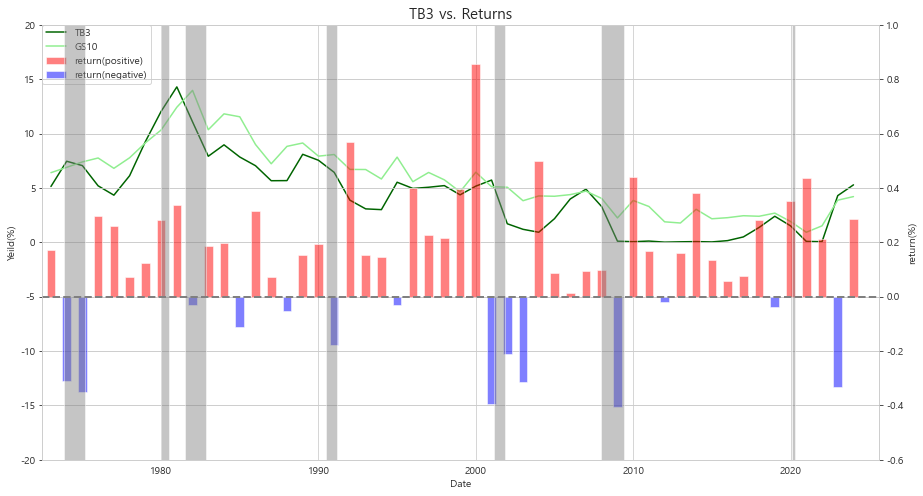

In [15]:
## 시각화
data = dataset.copy()

data[['TB3', 'GS10']] = rate_data[['TB3M', 'GS10Y']].copy()
data = data.fillna(method = 'pad')

data = data.resample('Y').last()

data['return'] = data[ticker].pct_change()
data = data.dropna(subset = ['TB3', 'GS10', 'return'])


fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
line1 = ax1.plot(data.index, data['TB3'],
         color="darkgreen", label="TB3")
line2 = ax1.plot(data.index, data['GS10'],
         color="lightgreen", label="GS10")
performance_plus = data['return'][data['return']>=0]
ax2.bar(performance_plus.index, performance_plus,
        color="red", alpha=0.5, width=200, label="return(positive)")

performance_minus = data['return'][data['return']<0]
ax2.bar(performance_minus.index, performance_minus,
        color="blue", alpha=0.5, width=200, label="return(negative)")
ax2.axhline(0, color='gray', linestyle='--', linewidth=2)

plt.tick_params(labelsize=10)  # font size of tick labels
plt.title("TB3 vs. Returns", fontsize=15)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
ax1.set_xlabel("Date")
ax1.set_ylabel("Yeild(%)")
ax1.set_ylim([-20, 20])
ax1.set_xlim([min(data.index) - dt.timedelta(days=200),
              max(data.index) + dt.timedelta(days=600)])

ax2.set_ylabel("return(%)")
ax2.set_ylim([-.6, 1])


## 경기침체
plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)
## plt.axvspan('2023-09-01', '2024-03-31', facecolor='gray', alpha=0.45)

plt.show()

### Oil-shock

In [16]:
df_sig_p1 = get_signals(dataset["1971-06-01":"1977"], ticker)

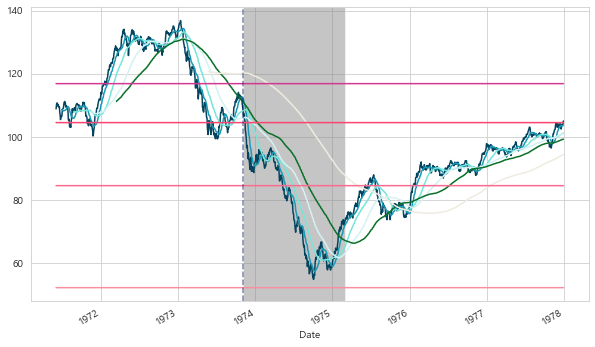

In [38]:
df_sig_p1.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#0A7029',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-11-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

<AxesSubplot:>

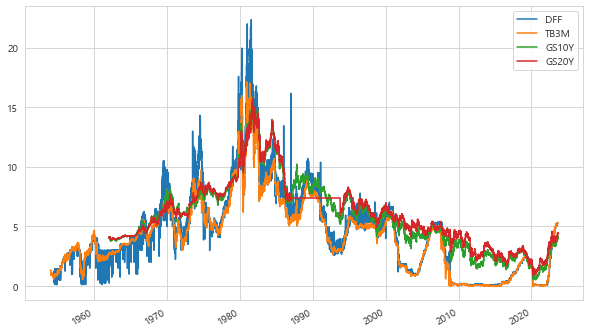

In [66]:
rate_df[:][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()

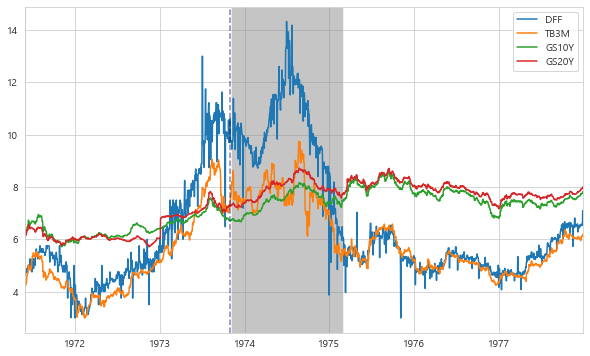

In [39]:
rate_df['1971-06-01':'1977-12-30'][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-11-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

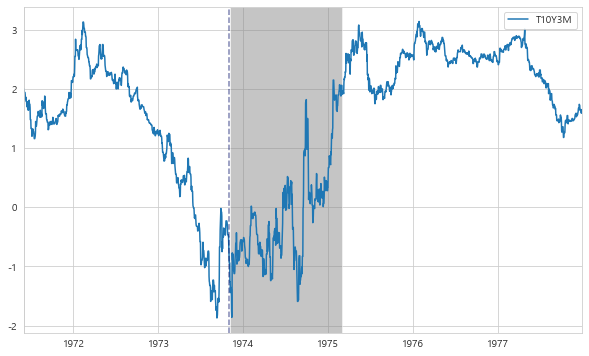

In [40]:
rate_data[['T10Y3M']]['1971-06-01':'1977-12-30'].plot()
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-11-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

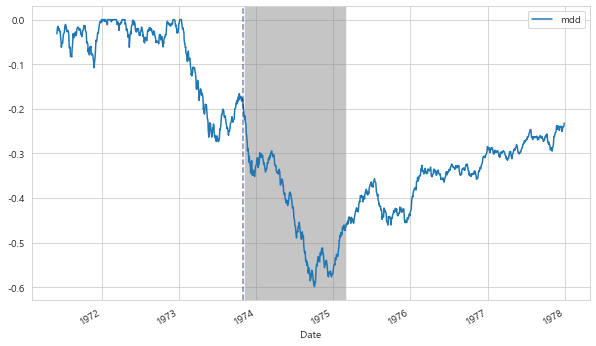

In [41]:
mdd_df[['mdd']]['1971-06-01':'1977-12-30'].plot()
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-11-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

### Dot-com

In [42]:
df_sig_p2 = get_signals(dataset["1999":"2003"], ticker)

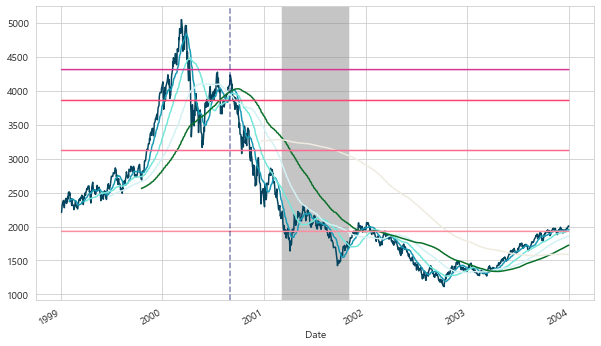

In [47]:
df_sig_p2.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#0A7029',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

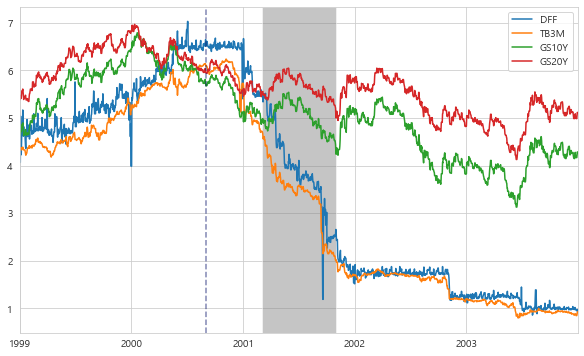

In [48]:
rate_df["1999":"2003"][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

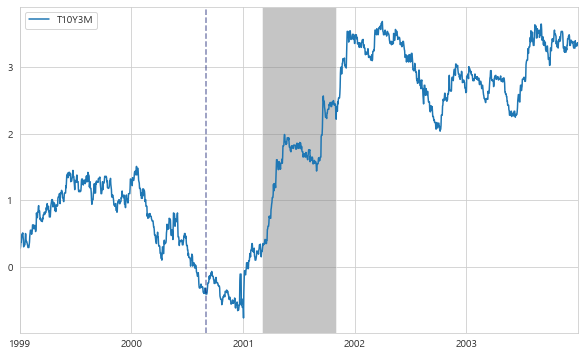

In [49]:
rate_data[['T10Y3M']]["1999":"2003"].plot()
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

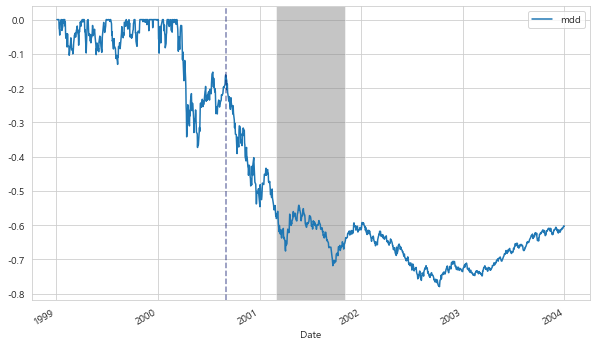

In [50]:
mdd_df[['mdd']]["1999":"2003"].plot()
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

### Sub-prime

In [51]:
df_sig_p3 = get_signals(dataset["2005":"2010"], ticker)

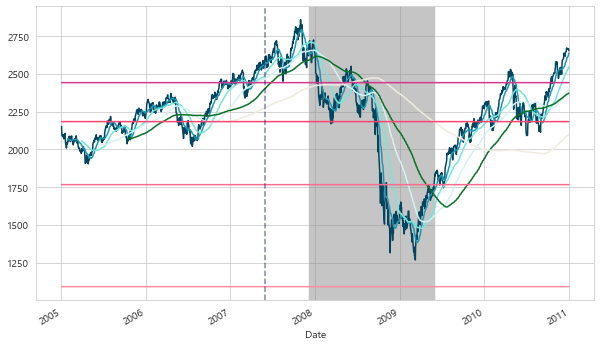

In [55]:
df_sig_p3.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#0A7029',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvline(x = '2007-06-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

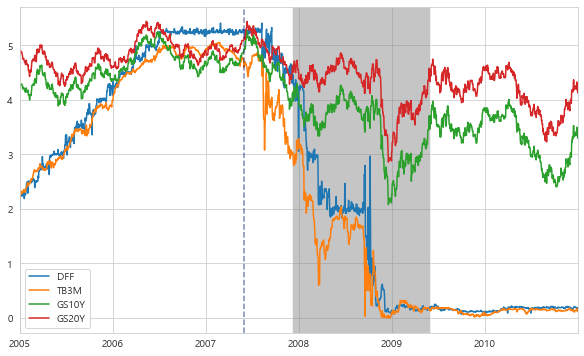

In [54]:
rate_df["2005":"2010"][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvline(x = '2007-06-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

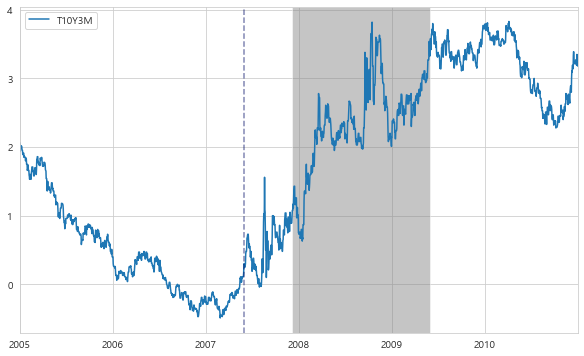

In [56]:
rate_data[['T10Y3M']]["2005":"2010"].plot()
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvline(x = '2007-06-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

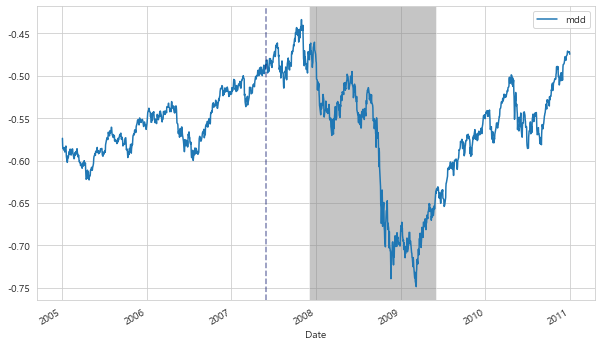

In [57]:
mdd_df[['mdd']]["2005":"2010"].plot()
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvline(x = '2007-06-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

### Now

In [58]:
df_sig_p4 = get_signals(dataset, ticker)
df_sig_p4 = df_sig_p4["2020-06-01":].copy()

In [59]:
df_sig_p4

,^IXIC,M20,M60,M120,M200,M500,F-4,F-3,F-2,F-1
Date,,,,,,,,,,
2020-06-01,9552.049805,9153.010449,8356.688314,8759.340405,8533.917595,7997.930680,6133.396472,9924.043958,12266.792944,13714.691444
2020-06-02,9608.379883,9197.893945,8373.900977,8767.561654,8543.126394,8001.768959,6133.396472,9924.043958,12266.792944,13714.691444
2020-06-03,9682.910156,9241.583447,8402.771476,8776.451074,8552.060994,8005.864640,6133.396472,9924.043958,12266.792944,13714.691444
2020-06-04,9615.809570,9279.654443,8423.964136,8784.465739,8560.125991,8009.805239,6133.396472,9924.043958,12266.792944,13714.691444
2020-06-05,9814.080078,9321.375439,8454.997974,8793.605404,8569.453591,8014.113539,6133.396472,9924.043958,12266.792944,13714.691444
...,...,...,...,...,...,...,...,...,...,...
2023-08-11,13644.849609,14060.306445,13595.834359,12735.757617,12083.493037,12876.392686,6133.396472,9924.043958,12266.792944,13714.691444
2023-08-14,13788.330078,14037.475439,13617.297021,12754.891203,12096.439087,12874.656986,6133.396472,9924.043958,12266.792944,13714.691444
2023-08-15,13631.049805,14001.345947,13633.000521,12772.591032,12109.739385,12872.867266,6133.396472,9924.043958,12266.792944,13714.691444


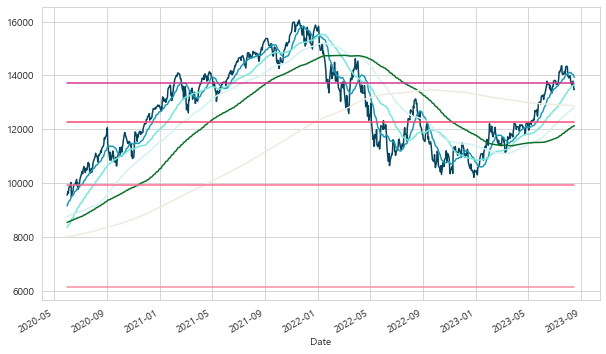

In [60]:
df_sig_p4.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#0A7029',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.show()

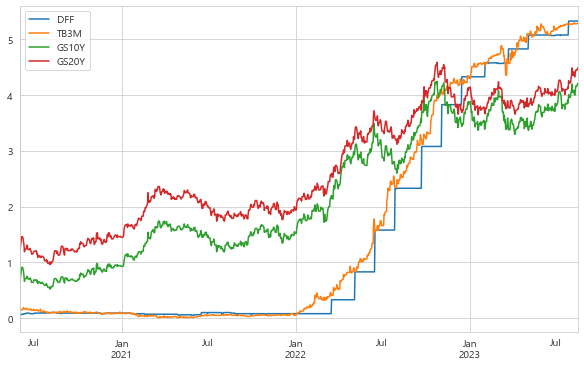

In [61]:
rate_df["2020-06-01":][['DFF', 'TB3M', 'GS10Y', 'GS20Y']].plot()
plt.show()

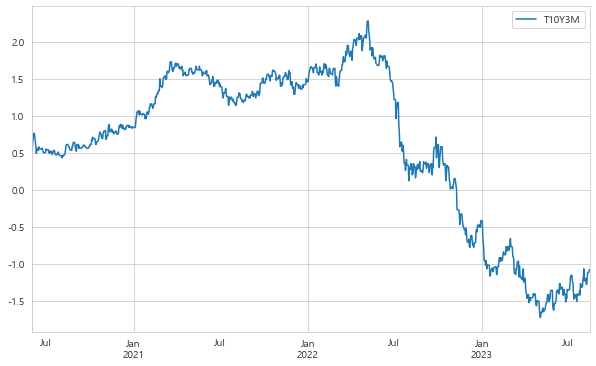

In [62]:
rate_data[['T10Y3M']]["2020-06-01":].plot()
plt.show()

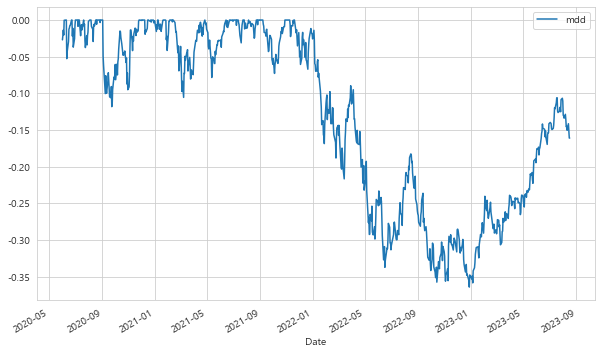

In [63]:
mdd_df[['mdd']]["2020-06-01":].plot()
plt.show()

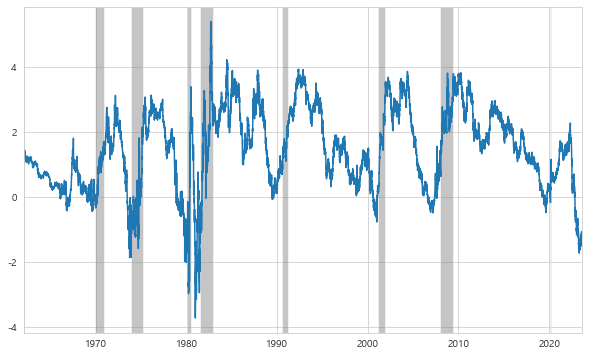

In [64]:
rate_data['T10Y3M'].plot()

plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)

plt.show()